In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import linregress

# Explanation of SARIMA parameters

In this notebook we develop documentation for easy reference that tell us what these mighty and enigmatic SARIMA model orders are. That's p, d, q, P, D, Q, S.

A SARIMA model is a time series model that lets you predict future values of some variable(s) of interest. It stands for Seasonal AutoRegressive Integrated Moving Average. Really, it can be thought of as three racoons standing on eachother's shoulders in a trench coat, which is to say that a SARIMA model is composed of three smaller time series models. Those are Autoregressive (AR) and Moving Average (MA), which together are Integrated (I) and combined with a Seasonal (S) component. It will be helpful to consider each little racoon as its own entity before looking at the whole coated figure. These are the three models that SARIMA is compose

- Autoregressive (AR) model.
A model unto its own! Tries to predict the future value of some target variable based on that target variable's values in the past. For example, what are tomorrow's used car sales? How many days back is most helpful for allowing us to predict tomorrow's sales? Only yesterday? Only 3 days ago? In essence, we're drawing a best fit line through a scatter plot of lagged data (the x values) and the current data (y values) to see which one has the least amount of error. You might be thinking "of course if we want to predict future values we'll have to do so from past values!" That's right, but the problem gets a little trickier when you consider that predicting the future in a world of uncertainties isn't a deterministic endeavor. SARIMA models acknowledge this by saying your predictions will ALWAYS have some error. That is to say, you can't predict the future with 100% certainty. This is worth pointing out not just for the philosophical point, but the mathematical implications: AR models use past values of the *target variable*, but ignore past error values. Your equation predicting the future will always need to append some uncertainty. This brings us to Moving Average Models.

- Moving Average (MA) model.

# To do list! Open Questions!

- How are the B's determined? Is that the work of the SARIMA model? How does it do that if so? 
- How is e determined?
- How do the equations for p (autoregressive) and q (moving average) integrate to form an ARIMA model?
- How do we determine scedasticity?
- What actually are each of the numbers in a pacf output? We know the pacf function plots autocorrelation at different lags, but how exactly are each autocorrelation computed?
    - Link where we left off investigating: https://online.stat.psu.edu/stat510/book/export/html/678#:~:text=Autocorrelation%20Function%20(PACF)-,2.2%20Partial%20Autocorrelation%20Function%20(PACF),some%20other%20set%20of%20variables.

### What is little p

p is the order of your autoregressive model. It is to how many lags back the model is to observe previous values of the target variable. If you're lookin to wrangle your p parameter pardner, you will be looking at the AR piece of the SARIMA model. Forget the other stuff for now, it's AR time. It'll start making sense when you take a look at the equation for an autoregresesive model 

The basic equation for an autoregressive model is this:

y<sub>t</sub> = B<sub>0</sub> + B<sub>1</sub>y<sub>t-1</sub> + e<sub>t</sub>

y<sub>t</sub> = the value you're trying to predict at time t<br />
y<sub>t-1</sub> = the previous value

B<sub>n</sub> = The coefficient of y at lag n. Consider y<sub>t</sub> = 3 + 2y<sub>t-1</sub> + e<sub>t</sub> <br /> 3 is the B value at t = 0 (B<sub>0</sub> = 3) and 2 is the B value at t-1 (B<sub>1</sub> = 2)

e = Error. All time series equations have inherent error, and e represents it. 

The y's can be subscripted down to whatever lag it needs to be. So like t-1 is one period ago, but it can be all the way back to t-n. 
So if I want to predict tomorrow's sales, that's y<sub>t</sub>. Today's sales would be y<sub>t-1</sub>.

So if you have an autoregressive equation that goes back 3 time periods then it's going to have all the way to t-3. E.g. an AR(3) would be 

y<sub>t</sub> = B<sub>0</sub> + B<sub>1</sub>y<sub>t-1</sub> + B<sub>2</sub>y<sub>t-2</sub> + B<sub>3</sub>y<sub>t-3</sub> + e<sub>t</sub>

### Identifying p

The Partial Autocorrelation Function (PACF) is most useful for identifying the order of an autoregressive model. A PACF is a function which you can plot to show how well the target values correlate with each other at various time lags, i.e. how well can you predict subsequent values from past ones. The x axis will be "lags," aka discrete time periods (if you're capturing data daily than one lag ago would be one day ago). The y axis will be how well the value of the target variable at that lag correlates with the most recent value of the target variable. Check out the image for elucidation!

![image](pacf_example.jpg "image")

So how do you use a PACF to find p? "large PACF values at a given lag indicate this value as a possible choice for the order of an autoregressive model." "For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor."

Should check PACF and ACF plots though and look for a pattern as well as when it dips below significance threshold. 

Values lying outside of either of these bounds (the significance thresholds of the PACF plots) are indicative of an autoregressive process.

*At this point we're curious about walking through the mathematical determination of a p. Specifically, we want to look at the relationship between the pacf plot and the p-value that you'll get for linear regression models at different lags.*

In pursuance of the above italicized text:
- grab some time series data (keep it simple)
- generate pacf plot of it
- run linear regression models at various time lags that seem relevant (probably just those hopeful few time lags that are above the significance threshold)
- compare corresponding p-values to their lag on the pacf plot
- Hypothesis: The last significant lag should be the one with the lowest (and therefore best) p_value. And that lag will be your p choice.

In [2]:
df = pd.read_csv('store41_deli.csv')
df.head()

,date,store_nbr,transactions,id,family,sales
0,2013-01-02,41,915,2946,DELI,206.435000
1,2013-01-03,41,809,4728,DELI,149.618000
2,2013-01-04,41,835,6510,DELI,112.590004
3,2013-01-05,41,1021,8292,DELI,161.583000
4,2013-01-06,41,1142,10074,DELI,228.133000


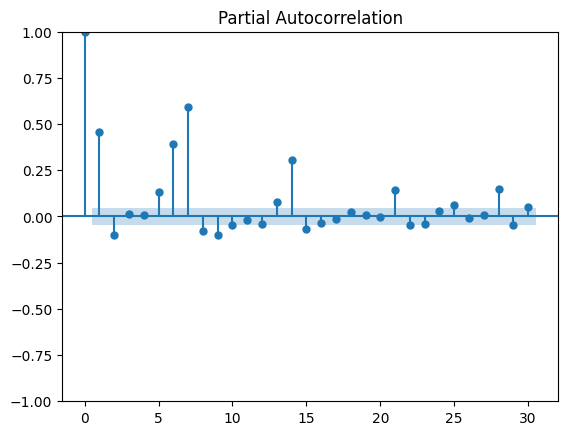

In [3]:
# So check it. Here is the pacf. Now we will move on to fiddling with the linear regression model to sort of try and rebuild what we're seeing with this pacf plot.
plot_pacf(df['sales'], lags = 30)
plt.show()

In [4]:
# Output the autocorrelation values for closer inspection (to taste)
pacf(df['sales'])

array([ 1.00000000e+00,  4.58017818e-01, -1.02064959e-01,  1.30209208e-02,
        8.89883233e-03,  1.30496753e-01,  3.92877395e-01,  5.95524409e-01,
       -7.85099655e-02, -1.00177667e-01, -4.72978605e-02, -2.06894143e-02,
       -4.07485527e-02,  7.99507778e-02,  3.12004783e-01, -6.69970931e-02,
       -3.61629185e-02, -1.49932447e-02,  2.20404747e-02,  5.93595091e-03,
        6.64174135e-04,  1.46019289e-01, -4.67177595e-02, -4.10570321e-02,
        2.93861062e-02,  6.57756767e-02, -6.29646404e-03,  9.91349427e-03,
        1.53815883e-01, -4.57941103e-02,  5.05528630e-02,  2.84916989e-02,
        4.52277405e-03])

In [5]:
# Create function to create lagged set of data back to specified lag
# Also reshapes data to match the lagged data length
def lag_maker(sales, lag):
    lag_n = sales.shift(periods = -lag)
    lag_n.dropna(inplace=True)
    
    length_n = len(lag_n)
    current_sales_lag_n = sales[:length_n]
    
    return current_sales_lag_n, lag_n

In [6]:
# Store p values
p_values = []
# Create list of lags
lags = [1, 2, 3, 4, 5, 6, 7]

# iterate through lags, calling the custom lag function and performing linear regression with current data and lagged data, storing p-values
for lag in lags:
    x, y = lag_maker(df['sales'], lag)

    # Perform linear regression
    result = linregress(x, y)

    # Print results
    p_values.append(result.pvalue)

In [7]:
p_values

[1.4055891883691538e-87,
 1.1696349061267449e-07,
 0.24225864209931627,
 0.584988896595316,
 5.643564297606656e-06,
 2.162685361094715e-68,
 1.0588965767569377e-281]

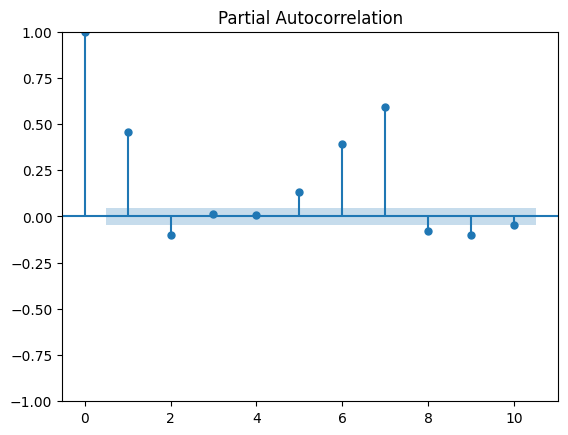

In [8]:
# Same pacf as above, just reproduced with the zoomies for ease of comparison
plot_pacf(df['sales'], lags = 10)
plt.show()

So what did we see with all of that?

There is a relationship with the p-value of a linear regression with the current data and itself at different lags. (And as a reminder, a linear regression statistical test seeks to test the alternative hypothesis that there is a linear relationship between two variables against the null hypothesis that there is none). There is an inverse relationship between p_value and correlation: as the p_value decreases, correlation increases.

In [9]:
# Calculate the Pearson correlation coefficient
correlation_matrix = np.corrcoef(lag_1, current_sales)
pearson_correlation = correlation_matrix[0, 1]

# Create the scatter plot
plt.scatter(lag_1, current_sales, color='blue', label='Data Points')

# Calculate the coefficients of the best fit line (slope and intercept)
coefficients = np.polyfit(lag_1, current_sales, 1)
slope, intercept = coefficients

# Create the best fit line
best_fit_line = slope * current_sales + intercept

# Plot the best fit line
plt.plot(lag_1, best_fit_line, color='red', label='Best Fit Line')

# Add labels and show the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Scatter Plot with Best Fit Line\nPearson Correlation: {pearson_correlation:.2f}')
plt.legend()
plt.savefig('line_of_life.png')
plt.show()

NameError: name 'lag_1' is not defined

# Bibliography 

On p: https://online.stat.psu.edu/stat501/book/export/html/996#:~:text=The%20order%20of%20an%20autoregression,value%20at%20the%20present%20time.